In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField,StringType, FloatType, IntegerType
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import create_map, struct, col, udf, desc

In [2]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import pyspark.sql.functions as F

%matplotlib inline

In [3]:
builder = SparkSession.builder.appName("QUALIS SPARK")
builder.config(
    "spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2")
builder.config("spark.speculation", "false")
builder.config("spark.sql.parquet.compression.codec", "gzip")
builder.config("spark.debug.maxToStringFields", "100")
builder.config("spark.driver.memory", "1g")
builder.config("spark.driver.cores", "1")
builder.config("spark.executor-memory", "20g")
builder.config("spark.executor.cores", "4")


builder.master("local[*]")

spark = builder.getOrCreate()
spark

In [6]:
file_score_entidade_ano = spark.read.parquet("score_entidade_ano")
file_score_entidade_ano.toPandas().head()

,SG_ENTIDADE_ENSINO,AN_BASE_PRODUCAO,TOTAL_SCORE
0,UNESP/SJRP,2015,12.2
1,INPE,2015,12.2
2,UNIOESTE,2015,1.2
3,UNIFACS,2015,1.2
4,IFCE,2014,2.1


In [7]:
max_score_year = file_score_entidade_ano\
    .select("SG_ENTIDADE_ENSINO", "TOTAL_SCORE", "AN_BASE_PRODUCAO")\
    .groupBy("AN_BASE_PRODUCAO")\
    .agg(F.max("TOTAL_SCORE").alias("MAX_SCORE"))\
    .orderBy("AN_BASE_PRODUCAO")

max_score_year.toPandas().head()


,AN_BASE_PRODUCAO,MAX_SCORE
0,2013,88.55
1,2014,97.95
2,2015,103.60
3,2016,104.45


In [8]:
entidade_score_year = file_score_entidade_ano\
    .select("SG_ENTIDADE_ENSINO", "TOTAL_SCORE", "AN_BASE_PRODUCAO")\
    .orderBy("AN_BASE_PRODUCAO")

entidade_score_year.toPandas().head()

,SG_ENTIDADE_ENSINO,TOTAL_SCORE,AN_BASE_PRODUCAO
0,UNESP/SJRP,10.25,2013
1,UDESC,1.20,2013
2,UNIVALI,0.90,2013
3,USP/SC,88.55,2013
4,UFPE,84.25,2013


In [20]:
max_score_year_entidade = entidade_score_year\
    .join(max_score_year,\
          [entidade_score_year["TOTAL_SCORE"] == max_score_year["MAX_SCORE"],\
           entidade_score_year["AN_BASE_PRODUCAO"] == max_score_year["AN_BASE_PRODUCAO"]],\
          how="inner")\
    .select(\
            entidade_score_year["AN_BASE_PRODUCAO"].cast(IntegerType()).alias("AN_BASE_PRODUCAO"),\
            "SG_ENTIDADE_ENSINO",\
            "MAX_SCORE").toPandas()

max_score_year_entidade.head()

,AN_BASE_PRODUCAO,SG_ENTIDADE_ENSINO,MAX_SCORE
0,2013,USP/SC,88.55
1,2014,USP/SC,97.95
2,2015,USP/SC,103.60
3,2016,UFPE,104.45


In [22]:
max_score_year_entidade.set_index("SG_ENTIDADE_ENSINO",drop=True,inplace=True)
max_score_year_entidade

,AN_BASE_PRODUCAO,MAX_SCORE
SG_ENTIDADE_ENSINO,,
USP/SC,2013,88.55
USP/SC,2014,97.95
USP/SC,2015,103.60
UFPE,2016,104.45


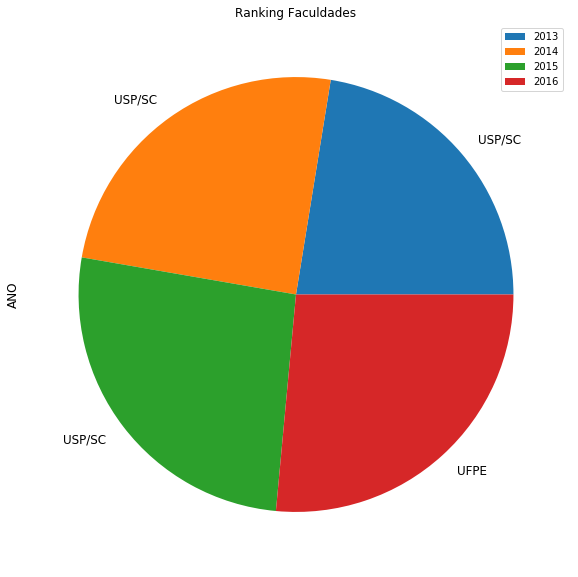

In [23]:
ax = max_score_year_entidade.plot(kind='pie', y="MAX_SCORE", title ="Ranking Faculdades", figsize=(15, 10), legend=True, fontsize=12)
a = ax.set_ylabel("ANO", fontsize=12)
a= ax.legend(['2013', '2014', '2015', '2016'])
